In [1]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
#import tensorflow as tf
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.optim.lr_scheduler import LinearLR

from transformers import AutoModelForImageClassification, ViTForImageClassification, \
                         ViTFeatureExtractor, Trainer, TrainingArguments, \
                         AutoFeatureExtractor, DeiTForImageClassificationWithTeacher, \
                         BeitForImageClassification, BeitFeatureExtractor
                         # PerceiverFeatureExtractor, PerceiverForImageClassificationConvProcessing

from AutoAugment.autoaugment import ImageNetPolicy

from PIL import Image

from tqdm import tqdm
from collections import defaultdict, OrderedDict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
df = pd.read_csv("./AML_project/data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)

df.shape

(31016, 2)

In [20]:
def remove_background(img):
    # Apply thresholds for the bound selection
    threshold1,threshold2 = 40, 500
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = cv2.Canny(img, threshold1, threshold2)

    # Convert images to correct sizes
    image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

    # Applying grey scale and applying the bounds --> These need to be optimized.
    new_image = img * image_new + (1 - grey_new)
    new_image = img * ((new_image > 40) * (new_image < 230))
    
    label = self.img_labels.iloc[idx, 1]
    new_image = torch.from_numpy(new_image).T

In [4]:
class food_set(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None, settype = "train"):
        if settype == "train":
            self.img_labels = df[:30000]
        elif settype == "val":
            self.img_labels = df[30000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        # image = remove_background(image)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image)["pixel_values"][0]      
        
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [5]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [6]:
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(768, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 81)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
model = model.to(device)

D:\ProgramData\Anaconda3\envs\R + Python\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

In [8]:
def train_loop(trainloader, valloader, model, criterion, optimizer, scheduler = None):
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(8.7)
        stats["accuracy"].append(1.25)

        for epoch in range(30):
            size = len(trainloader.dataset)

            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)["logits"]
                loss = criterion(pred, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'./beit_2_fc_29k_30_epochs_imgnetpol.pth'
                torch.save(model.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()
            
            if scheduler:
                scheduler.step()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)["logits"]
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [9]:
weights = [i[0] for i in (1 / (df.groupby("label").count() / len(df) * 100)).values]
weights.append(0)
weights = torch.Tensor(np.array(weights)).to(device)

In [10]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0002, betas=[0.9, 0.999])

scheduler = LinearLR(optimizer)

In [11]:
img_dir = "./AML_project/data/train_set/train_set"
labels = "./AML_project/data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       ImageNetPolicy(),
                                       transforms.RandomHorizontalFlip()])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224)])

feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [12]:
trainset = food_set(labels, img_dir, feature_extractor, transform = train_transforms, settype = "train")
valset = food_set(labels, img_dir, feature_extractor, transform = test_transforms, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

len(trainset), len(valset)

(30000, 1016)

In [13]:
testset = food_test("./AML_project/data/test_set/test_set", feature_extractor)
testloader = DataLoader(testset, batch_size = 16)

len(testset)

7653

loss: 4.274935  [    0/30000] epoch: 1
loss: 3.995604  [ 1600/30000] epoch: 1
loss: 3.528111  [ 3200/30000] epoch: 1
loss: 2.604939  [ 4800/30000] epoch: 1
loss: 3.180972  [ 6400/30000] epoch: 1
loss: 3.175188  [ 8000/30000] epoch: 1
loss: 2.264183  [ 9600/30000] epoch: 1
loss: 1.191658  [11200/30000] epoch: 1
loss: 1.399140  [12800/30000] epoch: 1
loss: 1.355560  [14400/30000] epoch: 1
loss: 1.358298  [16000/30000] epoch: 1
loss: 2.224932  [17600/30000] epoch: 1
loss: 2.001862  [19200/30000] epoch: 1
loss: 1.388219  [20800/30000] epoch: 1
loss: 2.027771  [22400/30000] epoch: 1
loss: 1.889791  [24000/30000] epoch: 1
loss: 1.831497  [25600/30000] epoch: 1
loss: 1.151796  [27200/30000] epoch: 1
loss: 1.275721  [28800/30000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.233043 



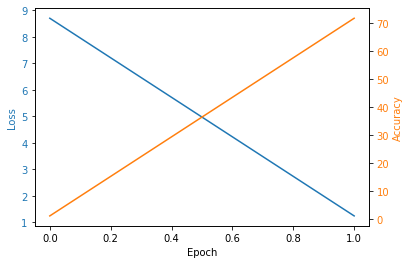

loss: 2.136448  [    0/30000] epoch: 2
loss: 1.723503  [ 1600/30000] epoch: 2
loss: 1.066329  [ 3200/30000] epoch: 2
loss: 1.128114  [ 4800/30000] epoch: 2
loss: 1.344029  [ 6400/30000] epoch: 2
loss: 1.270218  [ 8000/30000] epoch: 2
loss: 0.908488  [ 9600/30000] epoch: 2
loss: 1.769716  [11200/30000] epoch: 2
loss: 1.678433  [12800/30000] epoch: 2
loss: 2.723126  [14400/30000] epoch: 2
loss: 0.803857  [16000/30000] epoch: 2
loss: 1.154554  [17600/30000] epoch: 2
loss: 3.195869  [19200/30000] epoch: 2
loss: 2.296945  [20800/30000] epoch: 2
loss: 1.346776  [22400/30000] epoch: 2
loss: 0.299571  [24000/30000] epoch: 2
loss: 0.792293  [25600/30000] epoch: 2
loss: 1.411807  [27200/30000] epoch: 2
loss: 1.396614  [28800/30000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 73.9%, Avg loss: 1.075664 



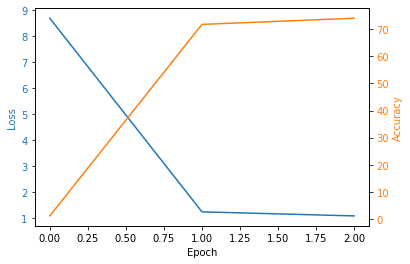

loss: 0.688713  [    0/30000] epoch: 3
loss: 1.333863  [ 1600/30000] epoch: 3
loss: 1.565628  [ 3200/30000] epoch: 3
loss: 0.988578  [ 4800/30000] epoch: 3
loss: 0.998556  [ 6400/30000] epoch: 3
loss: 1.077123  [ 8000/30000] epoch: 3
loss: 0.779162  [ 9600/30000] epoch: 3
loss: 0.524160  [11200/30000] epoch: 3
loss: 1.941092  [12800/30000] epoch: 3
loss: 1.186120  [14400/30000] epoch: 3
loss: 0.663513  [16000/30000] epoch: 3
loss: 1.052679  [17600/30000] epoch: 3
loss: 0.677738  [19200/30000] epoch: 3
loss: 0.920755  [20800/30000] epoch: 3
loss: 0.996881  [22400/30000] epoch: 3
loss: 0.859686  [24000/30000] epoch: 3
loss: 1.648194  [25600/30000] epoch: 3
loss: 1.305320  [27200/30000] epoch: 3
loss: 0.383338  [28800/30000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 75.0%, Avg loss: 1.021030 



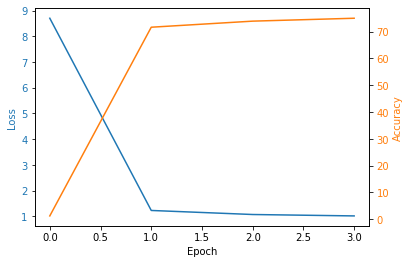

loss: 0.637051  [    0/30000] epoch: 4
loss: 1.379731  [ 1600/30000] epoch: 4
loss: 1.314499  [ 3200/30000] epoch: 4
loss: 2.198177  [ 4800/30000] epoch: 4
loss: 1.579499  [ 6400/30000] epoch: 4
loss: 0.923094  [ 8000/30000] epoch: 4
loss: 0.939164  [ 9600/30000] epoch: 4
loss: 1.878509  [11200/30000] epoch: 4
loss: 2.701683  [12800/30000] epoch: 4
loss: 1.442284  [14400/30000] epoch: 4
loss: 1.211931  [16000/30000] epoch: 4
loss: 0.366345  [17600/30000] epoch: 4
loss: 1.644950  [19200/30000] epoch: 4
loss: 0.467364  [20800/30000] epoch: 4
loss: 0.443961  [22400/30000] epoch: 4
loss: 0.487787  [24000/30000] epoch: 4
loss: 0.465603  [25600/30000] epoch: 4
loss: 0.583705  [27200/30000] epoch: 4
loss: 1.876965  [28800/30000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 75.1%, Avg loss: 0.998374 



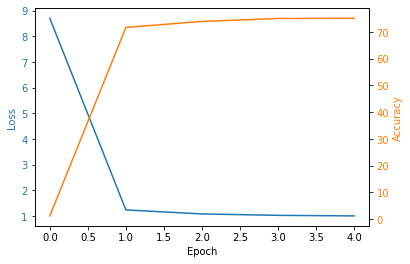

loss: 0.949725  [    0/30000] epoch: 5
loss: 0.762032  [ 1600/30000] epoch: 5
loss: 1.041285  [ 3200/30000] epoch: 5
loss: 1.588748  [ 4800/30000] epoch: 5
loss: 1.664175  [ 6400/30000] epoch: 5
loss: 1.769144  [ 8000/30000] epoch: 5
loss: 2.768731  [ 9600/30000] epoch: 5
loss: 1.341595  [11200/30000] epoch: 5
loss: 0.555558  [12800/30000] epoch: 5
loss: 1.360452  [14400/30000] epoch: 5
loss: 1.137593  [16000/30000] epoch: 5
loss: 1.473917  [17600/30000] epoch: 5
loss: 0.794913  [19200/30000] epoch: 5
loss: 0.830160  [20800/30000] epoch: 5
loss: 1.063168  [22400/30000] epoch: 5
loss: 0.312236  [24000/30000] epoch: 5
loss: 2.150779  [25600/30000] epoch: 5
loss: 0.944639  [27200/30000] epoch: 5
loss: 0.357609  [28800/30000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.981460 



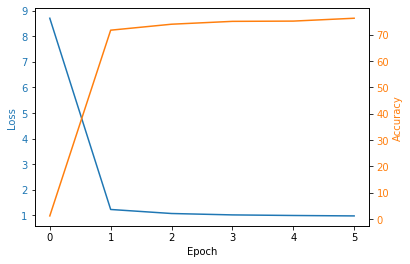

loss: 0.697233  [    0/30000] epoch: 6
loss: 0.718684  [ 1600/30000] epoch: 6
loss: 0.659637  [ 3200/30000] epoch: 6
loss: 1.856142  [ 4800/30000] epoch: 6
loss: 1.287447  [ 6400/30000] epoch: 6
loss: 1.634771  [ 8000/30000] epoch: 6
loss: 0.742881  [ 9600/30000] epoch: 6
loss: 1.679952  [11200/30000] epoch: 6
loss: 0.738275  [12800/30000] epoch: 6
loss: 1.126136  [14400/30000] epoch: 6
loss: 1.380671  [16000/30000] epoch: 6
loss: 0.653482  [17600/30000] epoch: 6
loss: 1.908726  [19200/30000] epoch: 6
loss: 0.239700  [20800/30000] epoch: 6
loss: 0.732532  [22400/30000] epoch: 6
loss: 1.349677  [24000/30000] epoch: 6
loss: 1.658165  [25600/30000] epoch: 6
loss: 0.729847  [27200/30000] epoch: 6
loss: 0.708252  [28800/30000] epoch: 6
Epoch: 6
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.947557 



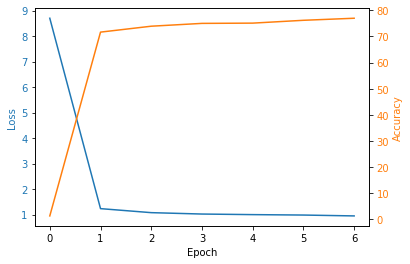

loss: 0.844557  [    0/30000] epoch: 7
loss: 1.387193  [ 1600/30000] epoch: 7
loss: 0.516334  [ 3200/30000] epoch: 7
loss: 1.166039  [ 4800/30000] epoch: 7
loss: 1.232118  [ 6400/30000] epoch: 7
loss: 2.514280  [ 8000/30000] epoch: 7
loss: 0.557853  [ 9600/30000] epoch: 7
loss: 1.241849  [11200/30000] epoch: 7
loss: 1.271494  [12800/30000] epoch: 7
loss: 1.091876  [14400/30000] epoch: 7
loss: 1.179923  [16000/30000] epoch: 7
loss: 0.923367  [17600/30000] epoch: 7
loss: 2.695683  [19200/30000] epoch: 7
loss: 0.551411  [20800/30000] epoch: 7
loss: 0.843443  [22400/30000] epoch: 7
loss: 1.092045  [24000/30000] epoch: 7
loss: 0.419986  [25600/30000] epoch: 7
loss: 1.596358  [27200/30000] epoch: 7
loss: 1.226753  [28800/30000] epoch: 7
Epoch: 7
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.949276 



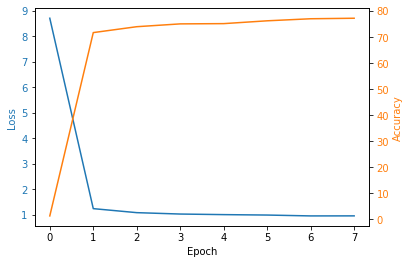

loss: 0.742161  [    0/30000] epoch: 8
loss: 1.424509  [ 1600/30000] epoch: 8
loss: 2.018077  [ 3200/30000] epoch: 8
loss: 0.680691  [ 4800/30000] epoch: 8
loss: 1.340968  [ 6400/30000] epoch: 8
loss: 1.394951  [ 8000/30000] epoch: 8
loss: 0.778265  [ 9600/30000] epoch: 8
loss: 0.349620  [11200/30000] epoch: 8
loss: 1.094919  [12800/30000] epoch: 8
loss: 2.191109  [14400/30000] epoch: 8
loss: 1.386460  [16000/30000] epoch: 8
loss: 0.814501  [17600/30000] epoch: 8
loss: 1.025014  [19200/30000] epoch: 8
loss: 0.914848  [20800/30000] epoch: 8
loss: 0.592360  [22400/30000] epoch: 8
loss: 1.685482  [24000/30000] epoch: 8
loss: 1.168463  [25600/30000] epoch: 8
loss: 1.383719  [27200/30000] epoch: 8
loss: 0.564190  [28800/30000] epoch: 8
Epoch: 8
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.937107 



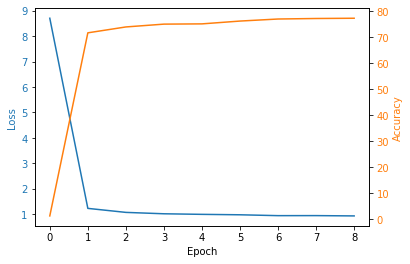

loss: 0.658624  [    0/30000] epoch: 9
loss: 1.453145  [ 1600/30000] epoch: 9
loss: 0.893993  [ 3200/30000] epoch: 9
loss: 1.305983  [ 4800/30000] epoch: 9
loss: 1.448450  [ 6400/30000] epoch: 9
loss: 0.754697  [ 8000/30000] epoch: 9
loss: 0.869188  [ 9600/30000] epoch: 9
loss: 0.376145  [11200/30000] epoch: 9
loss: 0.955487  [12800/30000] epoch: 9
loss: 1.632802  [14400/30000] epoch: 9
loss: 0.386502  [16000/30000] epoch: 9
loss: 0.395488  [17600/30000] epoch: 9
loss: 2.170669  [19200/30000] epoch: 9
loss: 0.402074  [20800/30000] epoch: 9
loss: 1.059795  [22400/30000] epoch: 9
loss: 0.399493  [24000/30000] epoch: 9
loss: 1.152103  [25600/30000] epoch: 9
loss: 1.252779  [27200/30000] epoch: 9
loss: 0.665434  [28800/30000] epoch: 9
Epoch: 9
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.936614 



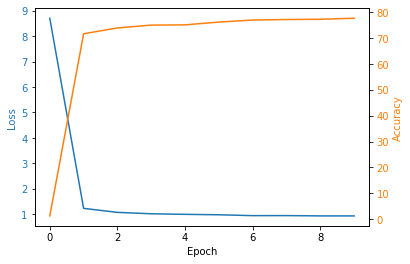

loss: 0.828269  [    0/30000] epoch: 10
loss: 0.611503  [ 1600/30000] epoch: 10
loss: 1.032218  [ 3200/30000] epoch: 10
loss: 1.088325  [ 4800/30000] epoch: 10
loss: 1.061686  [ 6400/30000] epoch: 10
loss: 1.876932  [ 8000/30000] epoch: 10
loss: 1.860061  [ 9600/30000] epoch: 10
loss: 0.921710  [11200/30000] epoch: 10
loss: 0.994373  [12800/30000] epoch: 10
loss: 0.252586  [14400/30000] epoch: 10
loss: 1.097796  [16000/30000] epoch: 10
loss: 0.256430  [17600/30000] epoch: 10
loss: 0.646441  [19200/30000] epoch: 10
loss: 0.357739  [20800/30000] epoch: 10
loss: 1.043359  [22400/30000] epoch: 10
loss: 1.299614  [24000/30000] epoch: 10
loss: 1.499126  [25600/30000] epoch: 10
loss: 1.863653  [27200/30000] epoch: 10
loss: 0.455045  [28800/30000] epoch: 10
Epoch: 10
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.955932 



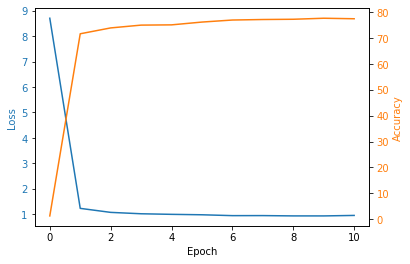

loss: 0.246732  [    0/30000] epoch: 11
loss: 1.525695  [ 1600/30000] epoch: 11
loss: 0.740639  [ 3200/30000] epoch: 11
loss: 0.421295  [ 4800/30000] epoch: 11
loss: 0.720149  [ 6400/30000] epoch: 11
loss: 0.339937  [ 8000/30000] epoch: 11
loss: 0.586611  [ 9600/30000] epoch: 11
loss: 0.403209  [11200/30000] epoch: 11
loss: 0.212152  [12800/30000] epoch: 11
loss: 1.528080  [14400/30000] epoch: 11
loss: 1.672400  [16000/30000] epoch: 11
loss: 1.084821  [17600/30000] epoch: 11
loss: 2.618675  [19200/30000] epoch: 11
loss: 1.368870  [20800/30000] epoch: 11
loss: 0.817478  [22400/30000] epoch: 11
loss: 0.940891  [24000/30000] epoch: 11
loss: 2.050820  [25600/30000] epoch: 11
loss: 0.640160  [27200/30000] epoch: 11
loss: 0.271176  [28800/30000] epoch: 11
Epoch: 11
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.939382 



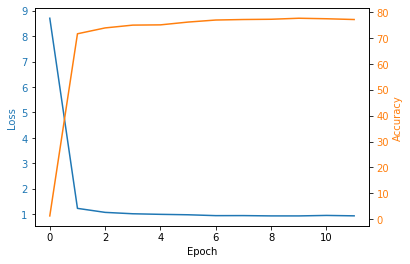

loss: 0.838929  [    0/30000] epoch: 12
loss: 0.676355  [ 1600/30000] epoch: 12
loss: 1.655941  [ 3200/30000] epoch: 12
loss: 2.030001  [ 4800/30000] epoch: 12
loss: 1.552658  [ 6400/30000] epoch: 12
loss: 1.267961  [ 8000/30000] epoch: 12
loss: 0.330743  [ 9600/30000] epoch: 12
loss: 0.828817  [11200/30000] epoch: 12
loss: 1.600343  [12800/30000] epoch: 12
loss: 1.756148  [14400/30000] epoch: 12
loss: 0.910657  [16000/30000] epoch: 12
loss: 0.759616  [17600/30000] epoch: 12
loss: 1.055416  [19200/30000] epoch: 12
loss: 0.751965  [20800/30000] epoch: 12
loss: 0.615599  [22400/30000] epoch: 12
loss: 0.155983  [24000/30000] epoch: 12
loss: 0.527137  [25600/30000] epoch: 12
loss: 1.932856  [27200/30000] epoch: 12
loss: 0.239137  [28800/30000] epoch: 12
Epoch: 12
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.947168 



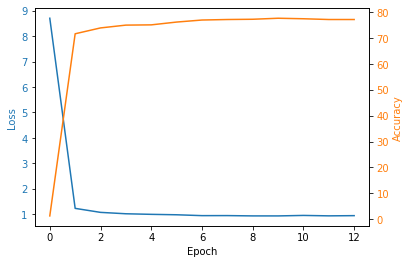

loss: 0.987852  [    0/30000] epoch: 13
loss: 1.461128  [ 1600/30000] epoch: 13
loss: 1.145820  [ 3200/30000] epoch: 13
loss: 0.454420  [ 4800/30000] epoch: 13
loss: 1.209185  [ 6400/30000] epoch: 13
loss: 1.360548  [ 8000/30000] epoch: 13
loss: 0.612341  [ 9600/30000] epoch: 13
loss: 1.413544  [11200/30000] epoch: 13
loss: 1.287717  [12800/30000] epoch: 13
loss: 0.200744  [14400/30000] epoch: 13
loss: 1.172864  [16000/30000] epoch: 13
loss: 1.310330  [17600/30000] epoch: 13
loss: 0.596125  [19200/30000] epoch: 13
loss: 0.102494  [20800/30000] epoch: 13
loss: 0.742964  [22400/30000] epoch: 13
loss: 0.633804  [24000/30000] epoch: 13
loss: 0.314024  [25600/30000] epoch: 13
loss: 0.958223  [27200/30000] epoch: 13
loss: 1.149618  [28800/30000] epoch: 13
Epoch: 13
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.915417 



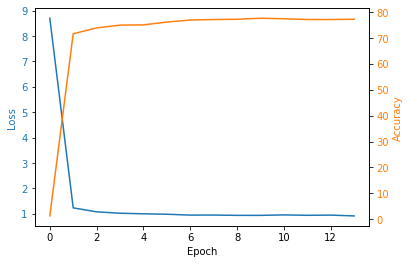

loss: 0.748829  [    0/30000] epoch: 14
loss: 0.798857  [ 1600/30000] epoch: 14
loss: 1.546087  [ 3200/30000] epoch: 14
loss: 1.322672  [ 4800/30000] epoch: 14
loss: 0.586427  [ 6400/30000] epoch: 14
loss: 0.108651  [ 8000/30000] epoch: 14
loss: 1.042628  [ 9600/30000] epoch: 14
loss: 0.686001  [11200/30000] epoch: 14
loss: 0.640347  [12800/30000] epoch: 14
loss: 0.667574  [14400/30000] epoch: 14
loss: 1.063272  [16000/30000] epoch: 14
loss: 0.692192  [17600/30000] epoch: 14
loss: 1.129451  [19200/30000] epoch: 14
loss: 1.557796  [20800/30000] epoch: 14
loss: 0.785576  [22400/30000] epoch: 14
loss: 0.513575  [24000/30000] epoch: 14
loss: 0.875291  [25600/30000] epoch: 14
loss: 1.367459  [27200/30000] epoch: 14
loss: 0.547562  [28800/30000] epoch: 14
Epoch: 14
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.959605 



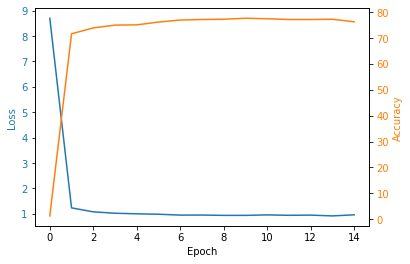

loss: 0.817082  [    0/30000] epoch: 15
loss: 0.180476  [ 1600/30000] epoch: 15
loss: 1.397563  [ 3200/30000] epoch: 15
loss: 1.556021  [ 4800/30000] epoch: 15
loss: 0.594795  [ 6400/30000] epoch: 15
loss: 1.339502  [ 8000/30000] epoch: 15
loss: 0.540818  [ 9600/30000] epoch: 15
loss: 1.050747  [11200/30000] epoch: 15
loss: 1.428698  [12800/30000] epoch: 15
loss: 1.302483  [14400/30000] epoch: 15
loss: 1.413473  [16000/30000] epoch: 15
loss: 0.997954  [17600/30000] epoch: 15
loss: 0.872660  [19200/30000] epoch: 15
loss: 0.637191  [20800/30000] epoch: 15
loss: 0.571134  [22400/30000] epoch: 15
loss: 1.606019  [24000/30000] epoch: 15
loss: 0.252356  [25600/30000] epoch: 15
loss: 0.349176  [27200/30000] epoch: 15
loss: 1.515477  [28800/30000] epoch: 15
Epoch: 15
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.947664 



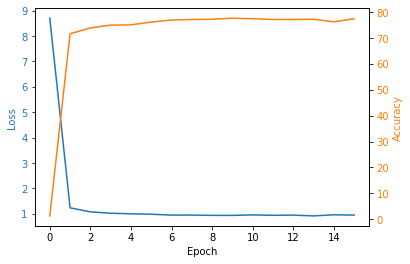

loss: 0.543271  [    0/30000] epoch: 16
loss: 0.748357  [ 1600/30000] epoch: 16
loss: 1.389761  [ 3200/30000] epoch: 16
loss: 1.001057  [ 4800/30000] epoch: 16
loss: 0.121835  [ 6400/30000] epoch: 16
loss: 1.025184  [ 8000/30000] epoch: 16
loss: 0.919458  [ 9600/30000] epoch: 16
loss: 1.084670  [11200/30000] epoch: 16
loss: 1.112888  [12800/30000] epoch: 16
loss: 2.080120  [14400/30000] epoch: 16
loss: 1.416334  [16000/30000] epoch: 16
loss: 1.237479  [17600/30000] epoch: 16
loss: 0.686879  [19200/30000] epoch: 16
loss: 1.072998  [20800/30000] epoch: 16
loss: 0.535998  [22400/30000] epoch: 16
loss: 0.169271  [24000/30000] epoch: 16
loss: 0.314640  [25600/30000] epoch: 16
loss: 0.548454  [27200/30000] epoch: 16
loss: 0.909365  [28800/30000] epoch: 16
Epoch: 16
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.939791 



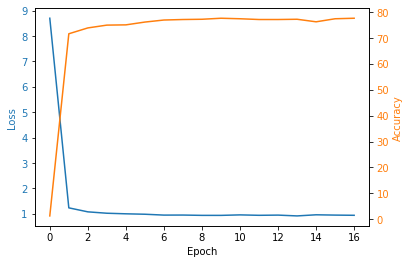

loss: 0.987554  [    0/30000] epoch: 17
loss: 0.863994  [ 1600/30000] epoch: 17
loss: 0.707544  [ 3200/30000] epoch: 17
loss: 1.162194  [ 4800/30000] epoch: 17
loss: 1.149170  [ 6400/30000] epoch: 17
loss: 1.733353  [ 8000/30000] epoch: 17
loss: 0.235087  [ 9600/30000] epoch: 17
loss: 1.122905  [11200/30000] epoch: 17
loss: 0.751008  [12800/30000] epoch: 17
loss: 0.997142  [14400/30000] epoch: 17
loss: 0.395147  [16000/30000] epoch: 17
loss: 0.206484  [17600/30000] epoch: 17
loss: 0.798271  [19200/30000] epoch: 17
loss: 1.364419  [20800/30000] epoch: 17
loss: 1.034012  [22400/30000] epoch: 17
loss: 0.976159  [24000/30000] epoch: 17
loss: 1.552289  [25600/30000] epoch: 17
loss: 1.507050  [27200/30000] epoch: 17
loss: 0.945504  [28800/30000] epoch: 17
Epoch: 17
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.957351 



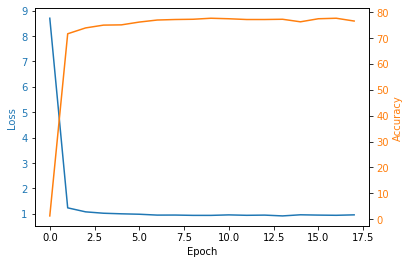

loss: 1.888457  [    0/30000] epoch: 18
loss: 1.293528  [ 1600/30000] epoch: 18
loss: 1.160431  [ 3200/30000] epoch: 18
loss: 1.184090  [ 4800/30000] epoch: 18
loss: 0.632536  [ 6400/30000] epoch: 18
loss: 0.521057  [ 8000/30000] epoch: 18
loss: 1.439994  [ 9600/30000] epoch: 18
loss: 0.577448  [11200/30000] epoch: 18
loss: 0.907894  [12800/30000] epoch: 18
loss: 1.344995  [14400/30000] epoch: 18
loss: 0.379891  [16000/30000] epoch: 18
loss: 0.035586  [17600/30000] epoch: 18
loss: 1.071126  [19200/30000] epoch: 18
loss: 0.800414  [20800/30000] epoch: 18
loss: 0.787240  [22400/30000] epoch: 18
loss: 1.061527  [24000/30000] epoch: 18
loss: 0.657702  [25600/30000] epoch: 18
loss: 1.078992  [27200/30000] epoch: 18
loss: 1.491615  [28800/30000] epoch: 18
Epoch: 18
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.947616 



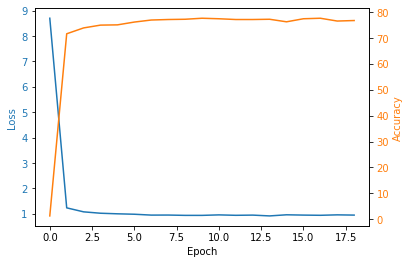

loss: 0.523411  [    0/30000] epoch: 19
loss: 0.408139  [ 1600/30000] epoch: 19
loss: 0.640092  [ 3200/30000] epoch: 19
loss: 0.736039  [ 4800/30000] epoch: 19
loss: 0.818031  [ 6400/30000] epoch: 19
loss: 0.258751  [ 8000/30000] epoch: 19
loss: 1.672669  [ 9600/30000] epoch: 19
loss: 0.470032  [11200/30000] epoch: 19
loss: 1.238327  [12800/30000] epoch: 19
loss: 0.549519  [14400/30000] epoch: 19
loss: 1.397755  [16000/30000] epoch: 19
loss: 0.942080  [17600/30000] epoch: 19
loss: 0.439820  [19200/30000] epoch: 19
loss: 0.961755  [20800/30000] epoch: 19
loss: 0.973074  [22400/30000] epoch: 19
loss: 0.761393  [24000/30000] epoch: 19
loss: 1.204519  [25600/30000] epoch: 19
loss: 0.363840  [27200/30000] epoch: 19
loss: 1.366011  [28800/30000] epoch: 19
Epoch: 19
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.952270 



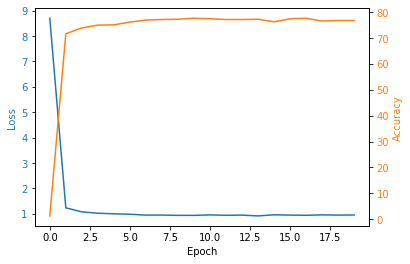

loss: 0.464977  [    0/30000] epoch: 20
loss: 0.852733  [ 1600/30000] epoch: 20
loss: 1.428585  [ 3200/30000] epoch: 20
loss: 0.921950  [ 4800/30000] epoch: 20
loss: 0.352009  [ 6400/30000] epoch: 20
loss: 0.455956  [ 8000/30000] epoch: 20
loss: 1.064131  [ 9600/30000] epoch: 20
loss: 0.342621  [11200/30000] epoch: 20
loss: 0.753243  [12800/30000] epoch: 20
loss: 0.809329  [14400/30000] epoch: 20
loss: 0.159633  [16000/30000] epoch: 20
loss: 1.134533  [17600/30000] epoch: 20
loss: 0.277366  [19200/30000] epoch: 20
loss: 1.130318  [20800/30000] epoch: 20
loss: 1.095483  [22400/30000] epoch: 20
loss: 0.752060  [24000/30000] epoch: 20
loss: 0.866947  [25600/30000] epoch: 20
loss: 0.874864  [27200/30000] epoch: 20
loss: 0.336397  [28800/30000] epoch: 20
Epoch: 20
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.950107 



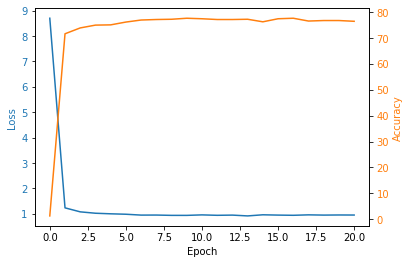

loss: 0.441085  [    0/30000] epoch: 21
loss: 2.112660  [ 1600/30000] epoch: 21
loss: 1.267174  [ 3200/30000] epoch: 21
loss: 0.387797  [ 4800/30000] epoch: 21
loss: 0.849075  [ 6400/30000] epoch: 21
loss: 0.423606  [ 8000/30000] epoch: 21
loss: 0.951678  [ 9600/30000] epoch: 21
loss: 1.665873  [11200/30000] epoch: 21
loss: 1.486696  [12800/30000] epoch: 21
loss: 2.788579  [14400/30000] epoch: 21
loss: 0.677765  [16000/30000] epoch: 21
loss: 1.051065  [17600/30000] epoch: 21
loss: 0.532686  [19200/30000] epoch: 21
loss: 0.599181  [20800/30000] epoch: 21
loss: 0.706138  [22400/30000] epoch: 21
loss: 1.459152  [24000/30000] epoch: 21
loss: 0.463934  [25600/30000] epoch: 21
loss: 1.330527  [27200/30000] epoch: 21
loss: 1.286041  [28800/30000] epoch: 21
Epoch: 21
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.935984 



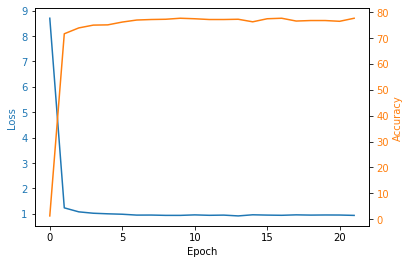

loss: 0.668200  [    0/30000] epoch: 22
loss: 1.271524  [ 1600/30000] epoch: 22
loss: 0.655142  [ 3200/30000] epoch: 22
loss: 0.836498  [ 4800/30000] epoch: 22
loss: 1.215303  [ 6400/30000] epoch: 22
loss: 1.624027  [ 8000/30000] epoch: 22
loss: 1.191800  [ 9600/30000] epoch: 22
loss: 0.970886  [11200/30000] epoch: 22
loss: 1.179700  [12800/30000] epoch: 22
loss: 1.571075  [14400/30000] epoch: 22
loss: 0.715140  [16000/30000] epoch: 22
loss: 1.376299  [17600/30000] epoch: 22
loss: 0.378745  [19200/30000] epoch: 22
loss: 0.297669  [20800/30000] epoch: 22
loss: 0.234332  [22400/30000] epoch: 22
loss: 0.374344  [24000/30000] epoch: 22
loss: 1.332415  [25600/30000] epoch: 22
loss: 1.176916  [27200/30000] epoch: 22
loss: 0.959411  [28800/30000] epoch: 22
Epoch: 22
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.944456 



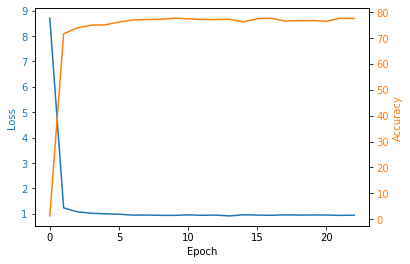

loss: 0.725983  [    0/30000] epoch: 23
loss: 1.589239  [ 1600/30000] epoch: 23
loss: 1.071348  [ 3200/30000] epoch: 23
loss: 1.576877  [ 4800/30000] epoch: 23
loss: 2.355659  [ 6400/30000] epoch: 23
loss: 2.369434  [ 8000/30000] epoch: 23
loss: 0.418881  [ 9600/30000] epoch: 23
loss: 0.138533  [11200/30000] epoch: 23
loss: 0.536464  [12800/30000] epoch: 23
loss: 0.477105  [14400/30000] epoch: 23
loss: 0.393193  [16000/30000] epoch: 23
loss: 0.568609  [17600/30000] epoch: 23
loss: 0.983388  [19200/30000] epoch: 23
loss: 0.708271  [20800/30000] epoch: 23
loss: 1.244292  [22400/30000] epoch: 23
loss: 1.752107  [24000/30000] epoch: 23
loss: 0.346577  [25600/30000] epoch: 23
loss: 0.451070  [27200/30000] epoch: 23
loss: 0.612040  [28800/30000] epoch: 23
Epoch: 23
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.938969 



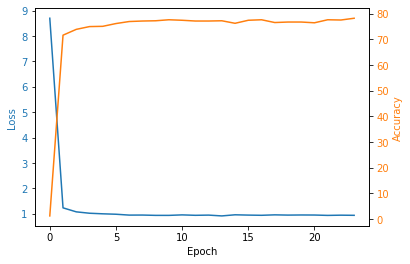

loss: 0.511881  [    0/30000] epoch: 24
loss: 0.980874  [ 1600/30000] epoch: 24
loss: 1.174956  [ 3200/30000] epoch: 24
loss: 0.164813  [ 4800/30000] epoch: 24
loss: 0.209895  [ 6400/30000] epoch: 24
loss: 1.733175  [ 8000/30000] epoch: 24
loss: 0.549460  [ 9600/30000] epoch: 24
loss: 0.745843  [11200/30000] epoch: 24
loss: 0.569355  [12800/30000] epoch: 24
loss: 1.739252  [14400/30000] epoch: 24
loss: 1.304827  [16000/30000] epoch: 24
loss: 0.326021  [17600/30000] epoch: 24
loss: 0.614659  [19200/30000] epoch: 24
loss: 0.738400  [20800/30000] epoch: 24
loss: 0.916556  [22400/30000] epoch: 24
loss: 0.786391  [24000/30000] epoch: 24
loss: 0.496796  [25600/30000] epoch: 24
loss: 2.244239  [27200/30000] epoch: 24
loss: 1.757390  [28800/30000] epoch: 24
Epoch: 24
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.954653 



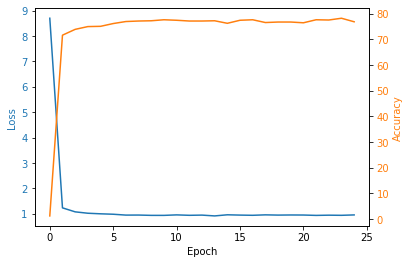

loss: 0.563922  [    0/30000] epoch: 25
loss: 1.605833  [ 1600/30000] epoch: 25
loss: 1.773920  [ 3200/30000] epoch: 25
loss: 0.189360  [ 4800/30000] epoch: 25
loss: 1.309399  [ 6400/30000] epoch: 25
loss: 1.222811  [ 8000/30000] epoch: 25
loss: 0.387262  [ 9600/30000] epoch: 25
loss: 0.360620  [11200/30000] epoch: 25
loss: 0.506384  [12800/30000] epoch: 25
loss: 0.638385  [14400/30000] epoch: 25
loss: 0.771471  [16000/30000] epoch: 25
loss: 1.067831  [17600/30000] epoch: 25
loss: 0.724520  [19200/30000] epoch: 25
loss: 1.072831  [20800/30000] epoch: 25
loss: 0.286133  [22400/30000] epoch: 25
loss: 0.828603  [24000/30000] epoch: 25
loss: 0.947312  [25600/30000] epoch: 25
loss: 1.552659  [27200/30000] epoch: 25
loss: 0.776504  [28800/30000] epoch: 25
Epoch: 25
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.955357 



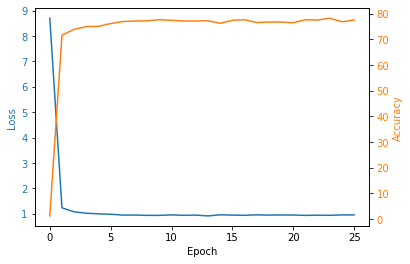

loss: 1.813409  [    0/30000] epoch: 26
loss: 1.155650  [ 1600/30000] epoch: 26
loss: 0.957787  [ 3200/30000] epoch: 26
loss: 1.111854  [ 4800/30000] epoch: 26
loss: 0.933327  [ 6400/30000] epoch: 26
loss: 0.833187  [ 8000/30000] epoch: 26
loss: 0.275194  [ 9600/30000] epoch: 26
loss: 1.387878  [11200/30000] epoch: 26
loss: 0.961737  [12800/30000] epoch: 26
loss: 0.838072  [14400/30000] epoch: 26
loss: 0.938779  [16000/30000] epoch: 26
loss: 2.167288  [17600/30000] epoch: 26
loss: 0.954430  [19200/30000] epoch: 26
loss: 1.044085  [20800/30000] epoch: 26
loss: 0.643682  [22400/30000] epoch: 26
loss: 0.706273  [24000/30000] epoch: 26
loss: 0.314871  [25600/30000] epoch: 26
loss: 0.942124  [27200/30000] epoch: 26
loss: 0.922387  [28800/30000] epoch: 26
Epoch: 26
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.951848 



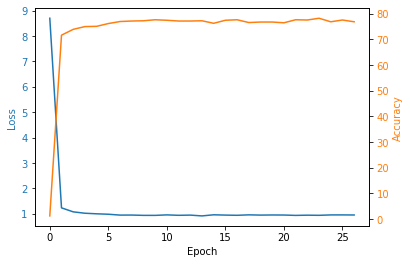

loss: 0.420002  [    0/30000] epoch: 27
loss: 0.892549  [ 1600/30000] epoch: 27
loss: 0.713519  [ 3200/30000] epoch: 27
loss: 0.247833  [ 4800/30000] epoch: 27
loss: 0.503776  [ 6400/30000] epoch: 27
loss: 1.112720  [ 8000/30000] epoch: 27
loss: 0.970277  [ 9600/30000] epoch: 27
loss: 0.632828  [11200/30000] epoch: 27
loss: 1.166179  [12800/30000] epoch: 27
loss: 0.487191  [14400/30000] epoch: 27
loss: 0.773077  [16000/30000] epoch: 27
loss: 0.582303  [17600/30000] epoch: 27
loss: 0.581053  [19200/30000] epoch: 27
loss: 0.542723  [20800/30000] epoch: 27
loss: 0.223631  [22400/30000] epoch: 27
loss: 0.769304  [24000/30000] epoch: 27
loss: 0.555417  [25600/30000] epoch: 27
loss: 1.287719  [27200/30000] epoch: 27
loss: 0.343323  [28800/30000] epoch: 27
Epoch: 27
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.938253 



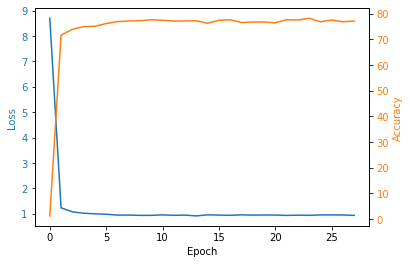

loss: 0.374751  [    0/30000] epoch: 28
loss: 0.309498  [ 1600/30000] epoch: 28
loss: 0.363887  [ 3200/30000] epoch: 28
loss: 0.489166  [ 4800/30000] epoch: 28
loss: 0.849527  [ 6400/30000] epoch: 28
loss: 1.106159  [ 8000/30000] epoch: 28
loss: 0.366325  [ 9600/30000] epoch: 28
loss: 1.179469  [11200/30000] epoch: 28
loss: 0.959427  [12800/30000] epoch: 28
loss: 0.065617  [14400/30000] epoch: 28
loss: 0.306684  [16000/30000] epoch: 28
loss: 0.856775  [17600/30000] epoch: 28
loss: 0.872490  [19200/30000] epoch: 28
loss: 0.502757  [20800/30000] epoch: 28
loss: 0.336784  [22400/30000] epoch: 28
loss: 0.819519  [24000/30000] epoch: 28
loss: 1.081372  [25600/30000] epoch: 28
loss: 1.217332  [27200/30000] epoch: 28
loss: 0.753004  [28800/30000] epoch: 28
Epoch: 28
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.950605 



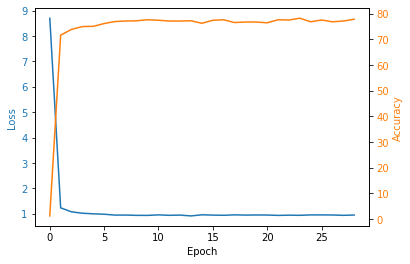

loss: 1.494657  [    0/30000] epoch: 29
loss: 1.015923  [ 1600/30000] epoch: 29
loss: 0.563450  [ 3200/30000] epoch: 29
loss: 0.442575  [ 4800/30000] epoch: 29
loss: 0.727205  [ 6400/30000] epoch: 29
loss: 0.677921  [ 8000/30000] epoch: 29
loss: 0.569660  [ 9600/30000] epoch: 29
loss: 1.083722  [11200/30000] epoch: 29
loss: 0.347367  [12800/30000] epoch: 29
loss: 0.609863  [14400/30000] epoch: 29
loss: 0.862099  [16000/30000] epoch: 29
loss: 1.478407  [17600/30000] epoch: 29
loss: 0.595034  [19200/30000] epoch: 29
loss: 0.424106  [20800/30000] epoch: 29
loss: 0.378421  [22400/30000] epoch: 29
loss: 0.611200  [24000/30000] epoch: 29
loss: 0.525717  [25600/30000] epoch: 29
loss: 0.212771  [27200/30000] epoch: 29
loss: 0.756448  [28800/30000] epoch: 29
Epoch: 29
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.966804 



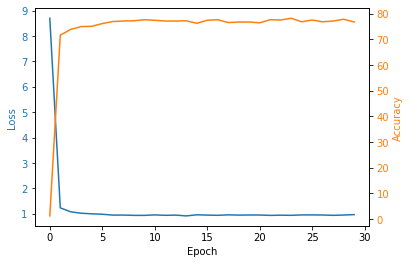

loss: 0.612022  [    0/30000] epoch: 30
loss: 0.379459  [ 1600/30000] epoch: 30
loss: 0.200172  [ 3200/30000] epoch: 30
loss: 1.884174  [ 4800/30000] epoch: 30
loss: 1.173116  [ 6400/30000] epoch: 30
loss: 1.718675  [ 8000/30000] epoch: 30
loss: 0.602518  [ 9600/30000] epoch: 30
loss: 0.293302  [11200/30000] epoch: 30
loss: 0.698217  [12800/30000] epoch: 30
loss: 1.202453  [14400/30000] epoch: 30
loss: 1.064701  [16000/30000] epoch: 30
loss: 0.763146  [17600/30000] epoch: 30
loss: 0.110448  [19200/30000] epoch: 30
loss: 1.132220  [20800/30000] epoch: 30
loss: 0.582885  [22400/30000] epoch: 30
loss: 1.896520  [24000/30000] epoch: 30
loss: 0.266955  [25600/30000] epoch: 30
loss: 0.831509  [27200/30000] epoch: 30
loss: 0.678587  [28800/30000] epoch: 30
Epoch: 30
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.963253 



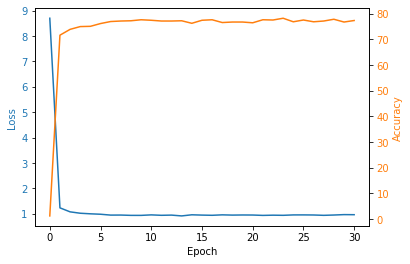

In [14]:
stats = train_loop(trainloader, valloader, model, criterion, optimizer)

In [15]:
pd.DataFrame(stats).to_csv("training_beit_data_aug_big_29k_30_epochs_imgnetpol.csv")

In [16]:
PATH = f'./beit_2_fc_29k_30_epochs_imgnetpol.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = model(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 479/479 [02:43<00:00,  2.94it/s]


In [18]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,80
1,test_10.jpg,45
2,test_100.jpg,25
3,test_1000.jpg,29
4,test_1001.jpg,37


In [19]:
test_df.to_csv("./submissions/submission_beit_fc2_30_epochs_imgnetpol.csv", index=False)